## Bayesian Anaylsis

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from nose.tools import assert_equal, assert_true, assert_is_instance
from numpy.testing import assert_array_almost_equal, assert_almost_equal

In [11]:
filename = 'Downloads/2001.csv'

usecols = (13, 16, 18)
columns = ['AirTime', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'PHL'] 
local = local.dropna() 
local = local.loc[::10000] 

print(local.head())

         AirTime Origin  Distance
15          53.0    PHL       290
513143     189.0    PHL      1324
1016250    278.0    PHL      2176
1545948     40.0    PHL       238
2059353    269.0    PHL      2176


### Linear Regression

In [18]:
def get_trace(X, y, n_samples=1000, random_seed=0):
    '''
    A simple Bayesian linear regression model with normal priors.
    
    Paramters
    ---------
    X: A numpy array
    y: A numpy array
    n_samples: The number of samples to draw in pymc3.sample().
               Defaults to 1000.
    random_seed: An int. Used in pymc3.sample().
                 Defaults to 0.
                 
    Returns
    -------
    A pymc3.MultiTrace object with access to sampling values.
    '''
    
    with pm.Model() as linear_model:
        alpha = pm.Normal('alpha', mu = 0.0, sd = 1.0 )
        beta = pm.Normal('beta', mu = 10.0, sd = 1.0)
        sigma = pm.Uniform('sigma', lower = 0, upper = 100)
        y_exp =  alpha + beta* X
        y = pm.Normal('y', mu=y_exp, sd=sigma, observed=y)
        start = pm.find_MAP()
        step = pm.NUTS(scaling=start)
        trace = pm.sample(n_samples, start=start, step=step, random_seed=random_seed)
    return trace

In [19]:
trace = get_trace(local.Distance.values, local.AirTime.values, n_samples=2000, random_seed=0)

Optimization terminated successfully.
         Current function value: 102.793545
         Iterations: 32
         Function evaluations: 36
         Gradient evaluations: 36


100%|██████████| 2500/2500 [00:02<00:00, 932.16it/s]


In [20]:
assert_is_instance(trace, pm.backends.base.MultiTrace)

In [22]:
assert_true('alpha' in trace.varnames)
assert_true('beta' in trace.varnames)
assert_true('sigma' in trace.varnames)

In [23]:
for v in trace.varnames:
    assert_equal(len(trace[v]), 2000)

### Visualizing

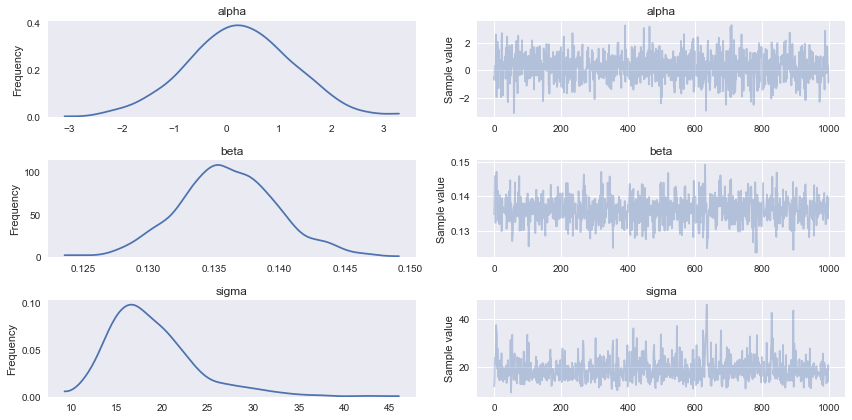

In [64]:
sns.set_style('darkgrid')
pm.traceplot(trace[-1000:], ['alpha', 'beta', 'sigma'])
plt.show()

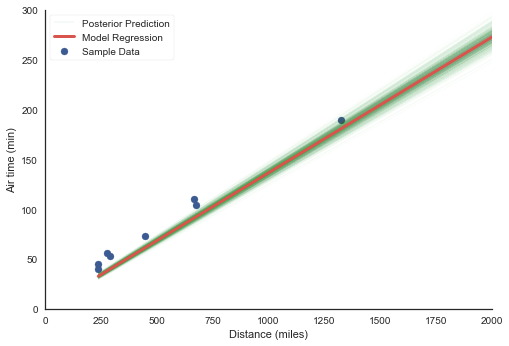

In [65]:
n_samples = 1000

x = local.Distance.values
y = local.AirTime.values

sns.set_style('white')

fig, ax = plt.subplots()

ax.scatter(x, y, c=sns.xkcd_rgb['denim blue'], label = 'Sample Data')

xl = x.min()
xh = x.max()

intercepts = trace['alpha'][-n_samples:]
slopes = trace['beta'][-n_samples:]

for m, b in zip(slopes, intercepts):
    yl = m * xl + b
    yh = m * xh + b
    ax.plot((xl, xh), (yl, yh), color=sns.xkcd_rgb['medium green'], lw=0.1, alpha = 0.1)


ax.plot((xl, xh), (yl, yh), color=sns.xkcd_rgb['medium green'], lw=0.1, label = 'Posterior Prediction')

m_fit = slopes.mean()
b_fit = intercepts.mean()

yfl = b_fit + m_fit * xl
yfh = b_fit + m_fit * xh
ax.plot((xl, xh), (yfl, yfh), color=sns.xkcd_rgb['pale red'], lw=3, label='Model Regression')

ax.set_xlim(0, 2000)
ax.set_ylim(0, 300)

ax.legend(loc='upper left', frameon=True)

ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Air time (min)')

sns.despine()
plt.show()